Processing variables (Spatial Unrolling)...
Merging and creating DataFrame...
Final Data Shape: (351424, 14)
Original Year Range: 1950 - 2025
Filtered Year Range: 1950 - 2021
Final Data Shape: (332928, 14)
Training HistGradientBoostingClassifier (Aggressive Tuning)...

--- Calculating Metrics ---
Running Cross-Validation (5-fold)...
Accuracy on training set: 0.883402
Accuracy on test set:     0.842865
Average Accuracy (CV):    0.7157
95% Confidence Interval:  0.7157 ± 0.1044
                          (0.6113 - 0.8202)

Classification Report:
              precision    recall  f1-score   support

    Pre-1990       0.84      0.89      0.86     36992
   Post-1990       0.85      0.79      0.82     29594

    accuracy                           0.84     66586
   macro avg       0.84      0.84      0.84     66586
weighted avg       0.84      0.84      0.84     66586



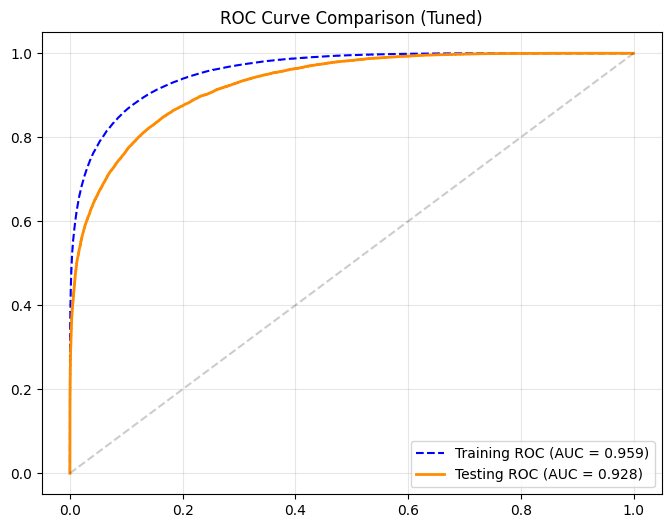

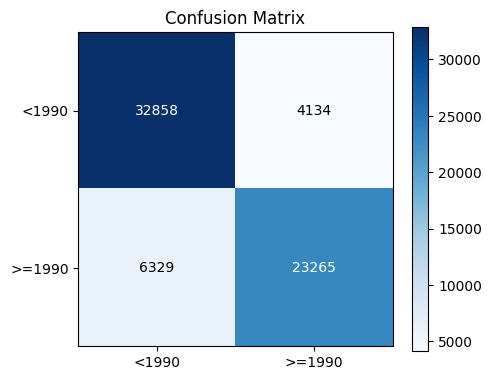

Generating Classifier Output Histogram...


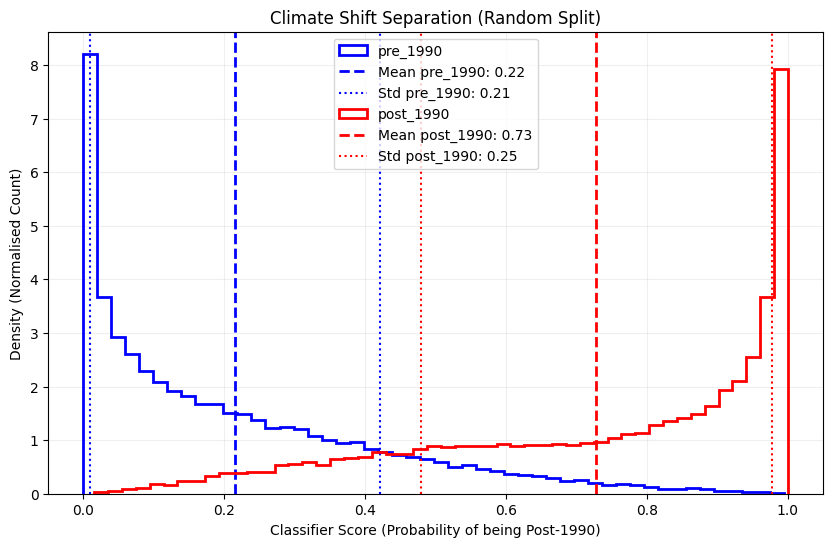

Calculating feature importance...


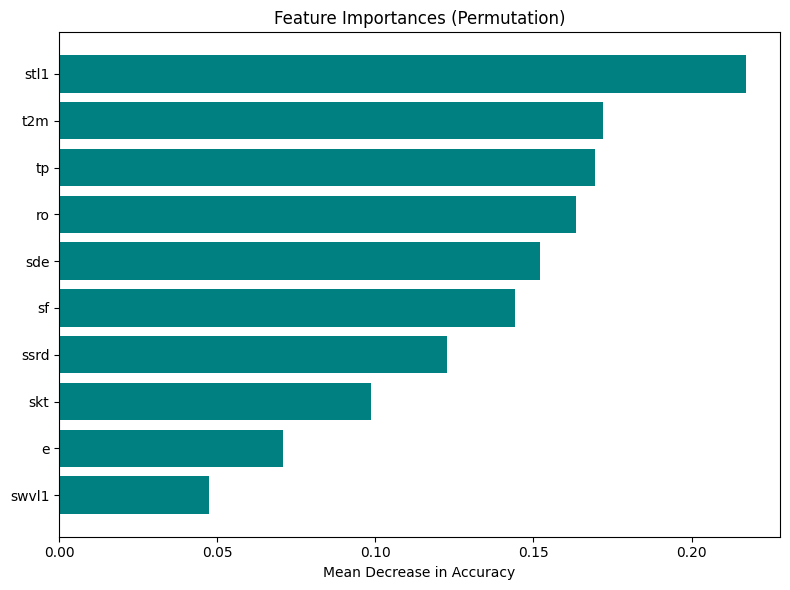

In [1]:
# Full Master Pipeline: TUNED for Better Separation
# - Increased model complexity (max_iter=1000, max_depth=15) to push separation
# - Includes all metrics and custom plots

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import (roc_curve, auc, confusion_matrix, classification_report)
from scipy.stats import sem, t
import joblib
import os

# ---------------------------
# 1. User settings / file paths
# ---------------------------
file_path = '/Users/ghosh/OneDrive/Documents/Year 4/Final project/11variables.nc'
out_folder = '/Users/ghosh/OneDrive/Documents/Year 4/Final project/ml_outputs_tuned'
os.makedirs(out_folder, exist_ok=True)

model_outfile = os.path.join(out_folder, 'gbdt_tuned_model.joblib')
pred_csv = os.path.join(out_folder, 'gbdt_test_predictions.csv')

# ---------------------------
# 2. Data Loading & Processing
# ---------------------------
vars_10 = ['t2m', 'skt', 'stl1', 'swvl1', 'sde', 'tp', 'e', 'ro', 'sf', 'ssrd']
ds = xr.open_dataset(file_path)
missing = [v for v in vars_10 if v not in ds.data_vars]
if missing: raise RuntimeError(f"Missing: {missing}")

# UK Subset
N, S, E, W = 61, 49, 2, -10
uk = ds.sel(latitude=slice(N, S), longitude=slice(W, E))
time_coord = 'valid_time' if 'valid_time' in uk.coords else list(uk.coords)[0]

# Monthly -> Yearly Logic
days = uk[time_coord].dt.days_in_month # simple list of numbers: [31, 28, 31, 30...], It tells the computer how long each time step lasted
days_3d = days.broadcast_like(uk['t2m']) # 1D list and stretches it out to match the full 3D shape of datafile
yearly_das = []
seconds_per_year = 365.25 * 24 * 3600.0

print("Processing variables (Spatial Unrolling)...")
for v in vars_10:
    da = uk[v]
    if v in ['tp', 'e', 'ro', 'sf']: # Accumulation
        yearly_da = (da * days_3d).groupby(uk[time_coord].dt.year).sum(dim=time_coord) * 1000.0 # m to mm
    elif v == 'ssrd': # Keep as Energy, not power
        yearly_da = da.groupby(uk[time_coord].dt.year).sum(dim=time_coord) / seconds_per_year
    else: # State
        yearly_da = da.groupby(uk[time_coord].dt.year).mean(dim=time_coord)
        if v in ['t2m', 'skt', 'stl1']: yearly_da -= 273.15
    yearly_da.name = v
    yearly_das.append(yearly_da)

print("Merging and creating DataFrame...")
df = xr.merge(yearly_das).to_dataframe().reset_index()
df = df.dropna(how='any').reset_index(drop=True)
print(f"Final Data Shape: {df.shape}")

# --- FILTER: Remove 2022 and later ---
print(f"Original Year Range: {df['year'].min()} - {df['year'].max()}")
df = df[df['year'] < 2022]
print(f"Filtered Year Range: {df['year'].min()} - {df['year'].max()}")
# -------------------------------------
print(f"Final Data Shape: {df.shape}")

# ---------------------------
# 3. Features & Target
# ---------------------------
df['target'] = (df['year'] >= 1990).astype(int)
feature_cols = [c for c in df.columns if c not in ['year', 'target', 'latitude', 'longitude', 'number']]
X = df[feature_cols].values
y = df['target'].values

# Train/Test Split
X_train, X_test, y_train, y_test, years_train, years_test = train_test_split(
    X, y, df['year'].values, test_size=0.2, random_state=42, stratify=y
)

# ---------------------------
# 4. Train Model (TUNED SETTINGS)
# ---------------------------
print("Training HistGradientBoostingClassifier (Aggressive Tuning)...")
clf = HistGradientBoostingClassifier(
    max_iter=1000,       # More trees (was 100) -> pushes confidence
    max_depth=15,        # Deeper trees -> learns finer details
    learning_rate=0.15,  # Faster learning
    min_samples_leaf=40, # Prevents overfitting on noise
    random_state=42
)
clf.fit(X_train, y_train)

# ---------------------------
# 5. Advanced Metrics
# ---------------------------
print("\n--- Calculating Metrics ---")
acc_train = clf.score(X_train, y_train)
acc_test = clf.score(X_test, y_test)

# Cross Validation (CV)
print("Running Cross-Validation (5-fold)...")
cv_scores = cross_val_score(clf, X, y, cv=5, n_jobs=-1) 
mean_cv = cv_scores.mean()
std_cv = cv_scores.std()

mean_score = cv_scores.mean()
standard_error = sem(cv_scores)
confidence = 0.95
h = standard_error * t.ppf((1 + confidence) / 2, len(cv_scores) - 1)

print(f"Accuracy on training set: {acc_train:.6f}")
print(f"Accuracy on test set:     {acc_test:.6f}")
print(f"Average Accuracy (CV):    {mean_cv:.4f}")
print(f"95% Confidence Interval:  {mean_score:.4f} ± {h:.4f}")
print(f"                          ({mean_score - h:.4f} - {mean_score + h:.4f})")

y_pred = clf.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Pre-1990', 'Post-1990']))

# ---------------------------
# 6. Plot: Dual ROC
# ---------------------------
y_prob_test = clf.predict_proba(X_test)[:, 1]
y_prob_train = clf.predict_proba(X_train)[:, 1]

fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_test)
fpr_train, tpr_train, _ = roc_curve(y_train, y_prob_train)
auc_test = auc(fpr_test, tpr_test)
auc_train = auc(fpr_train, tpr_train)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f'Training ROC (AUC = {auc_train:.3f})', linestyle='--', color='blue')
plt.plot(fpr_test, tpr_test, label=f'Testing ROC (AUC = {auc_test:.3f})', linewidth=2, color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.2)
plt.title('ROC Curve Comparison (Tuned)')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig(os.path.join(out_folder, 'roc_comparison_tuned.png'), dpi=150)
plt.show()

# ---------------------------
# 7. Plot: Confusion Matrix
# ---------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xticks([0, 1], ['<1990', '>=1990'])
plt.yticks([0, 1], ['<1990', '>=1990'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black' if cm[i,j] < cm.max()/2 else 'white')
plt.tight_layout()
plt.savefig(os.path.join(out_folder, 'confusion_matrix.png'), dpi=150)
plt.show()


# ---------------------------
# 8. Plot: Classifier Output Histogram (Random Split)
# ---------------------------
print("Generating Classifier Output Histogram...")

# Separate the probabilities for the two classes
probs_pre = y_prob_test[y_test == 0]
probs_post = y_prob_test[y_test == 1]

# Calculate Statistics
mu_pre = np.mean(probs_pre)
std_pre = np.std(probs_pre)
mu_post = np.mean(probs_post)
std_post = np.std(probs_post)

plt.figure(figsize=(10, 6))

# --- Plot Pre-1990 (Blue) ---
# 1. The Histogram
plt.hist(probs_pre, bins=50, histtype='step', color='blue', linewidth=2, density=True, label='pre_1990')
# 2. The Mean Line
plt.axvline(mu_pre, color='blue', linestyle='--', linewidth=2, label=f'Mean pre_1990: {mu_pre:.2f}')
# 3. The Std Dev Lines
plt.axvline(mu_pre - std_pre, color='blue', linestyle=':', linewidth=1.5, label=f'Std pre_1990: {std_pre:.2f}')
plt.axvline(mu_pre + std_pre, color='blue', linestyle=':', linewidth=1.5)

# --- Plot Post-1990 (Red) ---
# 1. The Histogram
plt.hist(probs_post, bins=50, histtype='step', color='red', linewidth=2, density=True, label='post_1990')
# 2. The Mean Line
plt.axvline(mu_post, color='red', linestyle='--', linewidth=2, label=f'Mean post_1990: {mu_post:.2f}')
# 3. The Std Dev Lines
plt.axvline(mu_post - std_post, color='red', linestyle=':', linewidth=1.5, label=f'Std post_1990: {std_post:.2f}')
plt.axvline(mu_post + std_post, color='red', linestyle=':', linewidth=1.5)

# --- Final Formatting ---
plt.xlabel('Classifier Score (Probability of being Post-1990)')
plt.ylabel('Density (Normalised Count)')
plt.title('Climate Shift Separation (Random Split)')
plt.legend(loc='best')
plt.grid(alpha=0.2)
#plt.savefig(os.path.join(out_folder, 'classifier_output_random_stats.png'), dpi=150)
plt.show()


# ---------------------------
# 9. Plot: Feature Importances
# ---------------------------
print("Calculating feature importance...")
result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
importances = result.importances_mean
feat_order = np.argsort(importances)[::-1]
labels = np.array(feature_cols)[feat_order]

plt.figure(figsize=(8, 6))
plt.barh(labels, importances[feat_order], color='teal')
plt.gca().invert_yaxis()
plt.title('Feature Importances (Permutation)')
plt.xlabel('Mean Decrease in Accuracy')
plt.tight_layout()
plt.show()

# adaboost and random forest too 

In [8]:
import xarray as xr

# 1. Load the file
file_path = '/Users/ghosh/OneDrive/Documents/Year 4/Final project/11variables.nc'
ds = xr.open_dataset(file_path)

# 2. Your 'Friendly' Map
var_map = {
    't2m': '2m Temperature', 
    'skt': 'Skin Temperature', 
    'stl1': 'Soil Temp Layer 1',
    'swvl1': 'Volumetric Soil Water', 
    'sde': 'Snow Depth', 
    'tp': 'Total Precipitation',
    'e': 'Evaporation', 
    'ro': 'Runoff', 
    'sf': 'Snowfall', 
    'ssrd': 'Surface Solar Radiation'
}

print("\n" + "="*60)
print(f"{'SHORT':<8} | {'NAME':<25} | {'OFFICIAL NETCDF DESCRIPTION'}")
print("="*60)

# 3. Loop through your list to print details
for var_code in var_map.keys():
    # Get the official description from the file metadata, if it exists
    if var_code in ds:
        official_name = ds[var_code].attrs.get('long_name', 'No metadata found')
        units = ds[var_code].attrs.get('units', '')
    else:
        official_name = "VARIABLE MISSING IN FILE"
        units = ""
        
    # Print the row
    print(f"{var_code:<8} | {var_map[var_code]:<25} | {official_name} ({units})")

print("="*60 + "\n")


SHORT    | NAME                      | OFFICIAL NETCDF DESCRIPTION
t2m      | 2m Temperature            | 2 metre temperature (K)
skt      | Skin Temperature          | Skin temperature (K)
stl1     | Soil Temp Layer 1         | Soil temperature level 1 (K)
swvl1    | Volumetric Soil Water     | Volumetric soil water layer 1 (m**3 m**-3)
sde      | Snow Depth                | Snow depth (m)
tp       | Total Precipitation       | Total precipitation (m)
e        | Evaporation               | Evaporation (m of water equivalent)
ro       | Runoff                    | Runoff (m)
sf       | Snowfall                  | Snowfall (m of water equivalent)
ssrd     | Surface Solar Radiation   | Surface short-wave (solar) radiation downwards (J m**-2)



Latitude Points:  121
Longitude Points: 121
Total Grid Pixels: 14641

--- The Forensic Report ---
Land Pixels (Keep):  4624
Ocean Pixels (Drop): 10017
Land Fraction:       31.58%


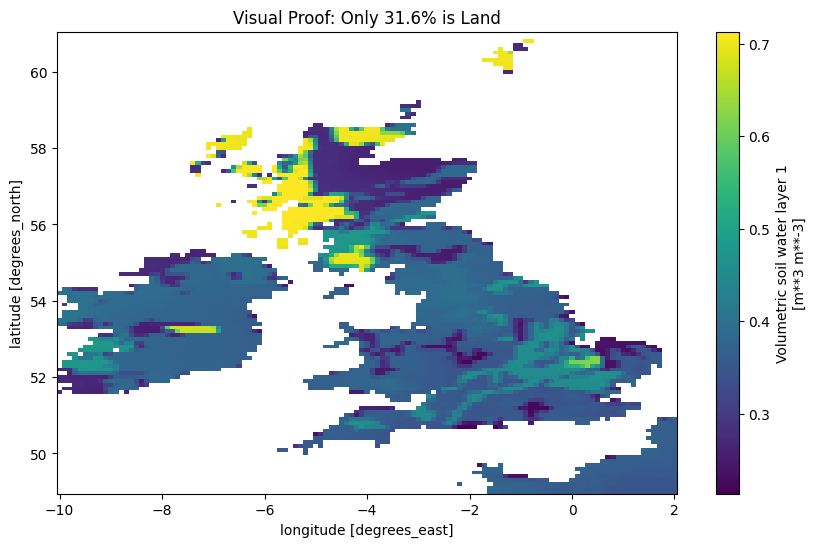

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# 1. Load Data
file_path = '/Users/ghosh/OneDrive/Documents/Year 4/Final project/11variables.nc'
ds = xr.open_dataset(file_path)

# 2. Select the Box
uk = ds.sel(latitude=slice(61, 49), longitude=slice(-10, 2))

# 3. Get Exact Counts
n_lat = len(uk.latitude)
n_lon = len(uk.longitude)
total_pixels = n_lat * n_lon

print(f"Latitude Points:  {n_lat}")
print(f"Longitude Points: {n_lon}")
print(f"Total Grid Pixels: {total_pixels}")

# 4. Check for 'Land Only' Variables
# 'swvl1' (Soil Water) is the best test because it implies LAND.
# If a pixel is Ocean, swvl1 will be NaN (Not a Number).
sample_map = uk['swvl1'].isel(valid_time=0) # Just look at the first day
n_land_pixels = int(sample_map.count().values) # Counts non-NaN values
n_ocean_pixels = total_pixels - n_land_pixels
land_fraction = (n_land_pixels / total_pixels) * 100

print(f"\n--- The Forensic Report ---")
print(f"Land Pixels (Keep):  {n_land_pixels}")
print(f"Ocean Pixels (Drop): {n_ocean_pixels}")
print(f"Land Fraction:       {land_fraction:.2f}%")

# 5. Visual Proof (The Map)
plt.figure(figsize=(10, 6))
sample_map.plot()
plt.title(f"Visual Proof: Only {land_fraction:.1f}% is Land")
plt.show()


--- 1. INITIAL LOADING & BOX DIMENSIONS ---
Latitude Points:  121
Longitude Points: 121
Total Grid Pixels: 14641
Total Years:       76
Expected Array Size (Pixels * Years): 1112716

--- 2. APPLYING STRICT UK MASK & FORENSIC REPORT ---
Land Pixels (Keep - UK Only): 3104
Dropped Pixels (Ocean/Ireland): 11537
Land Fraction: 21.20% (Lower than 31% because Ireland is gone)

--- 3. PROCESSING VARIABLES (Physics Logic) ---
Merging and creating DataFrame...

--- 4. COLUMN DETECTIVE ---
Total Columns found: 14
List of Columns: ['lat', 'lon', 'year', 'number', 't2m', 'skt', 'stl1', 'swvl1', 'sde', 'tp', 'e', 'ro', 'sf', 'ssrd']
Coordinate Columns (4): ['lat', 'lon', 'number', 'year'] (These are the 'extras')
Data Columns (10): ['t2m', 'skt', 'stl1', 'swvl1', 'sde', 'tp', 'e', 'ro', 'sf', 'ssrd']
------------------------
Final Data Shape (UK Land Only): (223488, 14)

--- 5. TRAINING MODEL ---

--- 6. VALIDATION METRICS ---
Accuracy (Train): 0.912976
Accuracy (Test):  0.863775
CV Average:       0

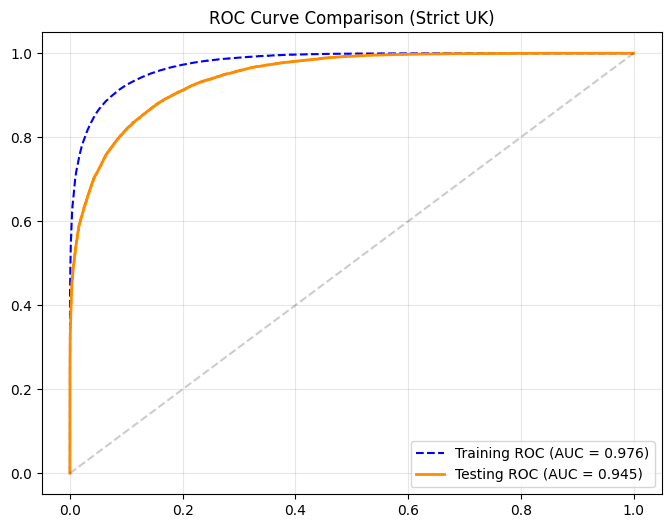


Generating Separation Histogram...
Pre-1990 Mean:  0.1894
Post-1990 Mean: 0.7654
Separation Z:   2.5288


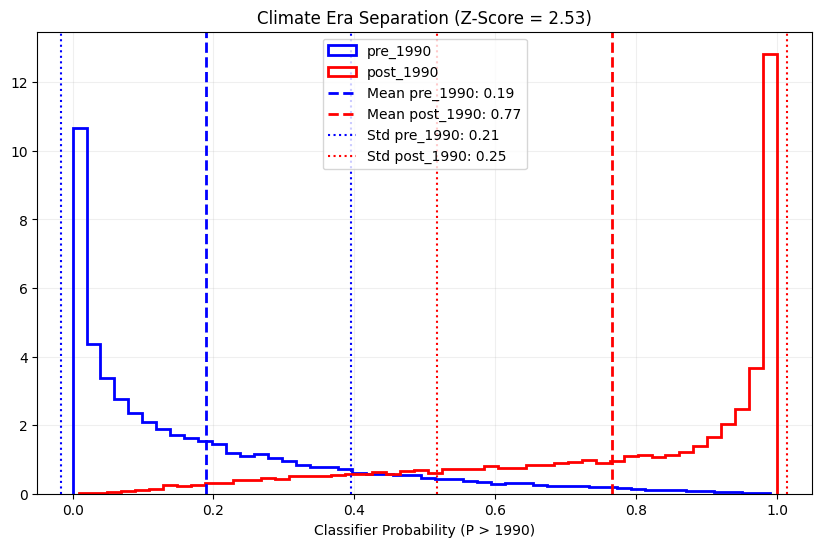

Calculating feature importance...


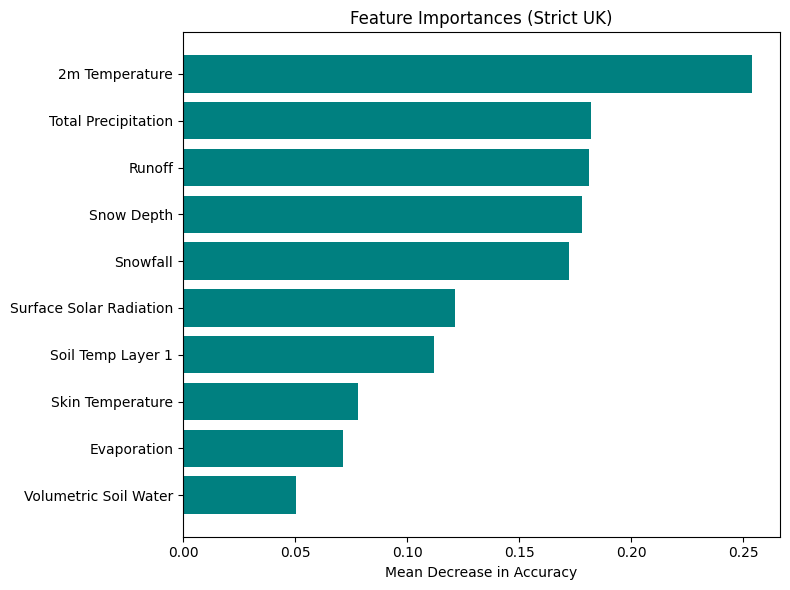


--- PIPELINE COMPLETE ---


In [5]:
# ==============================================================================
# MASTER CLIMATE THESIS PIPELINE: "Strict UK" Model + Full Diagnostics
# ==============================================================================
# 1. Loads Data & Calculates Theoretical Grid Size (The Box).
# 2. Masks out Republic of Ireland & Ocean (Strict UK Only).
# 3. Prints "Forensic Report" (Land vs Ocean pixel counts).
# 4. Processes Physics (Summing Fluxes vs Averaging States).
# 5. Prints "Column Detective" (Verifying variables).
# 6. Trains Model & Plots Histogram with Detailed Legend Stats.
# ==============================================================================

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import regionmask
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import (roc_curve, auc, confusion_matrix, classification_report)
from scipy.stats import sem, t
import os

# ---------------------------
# 1. User Settings
# ---------------------------
file_path = '/Users/ghosh/OneDrive/Documents/Year 4/Final project/11variables.nc'
out_folder = '/Users/ghosh/OneDrive/Documents/Year 4/Final project/ml_outputs_final_diagnostics'
os.makedirs(out_folder, exist_ok=True)

var_map = {
    't2m': '2m Temperature', 'skt': 'Skin Temperature', 'stl1': 'Soil Temp Layer 1',
    'swvl1': 'Volumetric Soil Water', 'sde': 'Snow Depth', 'tp': 'Total Precipitation',
    'e': 'Evaporation', 'ro': 'Runoff', 'sf': 'Snowfall', 'ssrd': 'Surface Solar Radiation'
}
vars_10 = list(var_map.keys())

# ---------------------------
# 2. Data Loading & Box Diagnostics
# ---------------------------
print("\n--- 1. INITIAL LOADING & BOX DIMENSIONS ---")
ds = xr.open_dataset(file_path)

# Define Bounding Box
N, S, E, W = 61, 49, 2, -10
uk_box = ds.sel(latitude=slice(N, S), longitude=slice(W, E))

# Rename for tools
uk_box = uk_box.rename({'longitude': 'lon', 'latitude': 'lat'})

# --- DIAGNOSTIC 1: THEORETICAL BOX SIZE ---
n_lat = len(uk_box.lat)
n_lon = len(uk_box.lon)
total_grid_pixels = n_lat * n_lon
n_years = len(np.unique(uk_box['valid_time' if 'valid_time' in uk_box else 'time'].dt.year))

print(f"Latitude Points:  {n_lat}")
print(f"Longitude Points: {n_lon}")
print(f"Total Grid Pixels: {total_grid_pixels}")
print(f"Total Years:       {n_years}")
print(f"Expected Array Size (Pixels * Years): {total_grid_pixels * n_years}")

# ---------------------------
# 3. Strict UK Masking & Forensic Report
# ---------------------------
print("\n--- 2. APPLYING STRICT UK MASK & FORENSIC REPORT ---")
countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_110
uk_index = countries.names.index('United Kingdom')

# Create Mask (True for UK, False for Ireland/Ocean)
mask = countries.mask(uk_box['lon'], uk_box['lat']) == uk_index
uk_masked = uk_box.where(mask)

# --- DIAGNOSTIC 2: THE FORENSIC REPORT (Land vs Ocean/Ireland) ---
# We check one time slice to count valid pixels
sample_slice = uk_masked['t2m'].isel(valid_time=0) # Just grab first day
n_land_pixels = int(sample_slice.count().values)   # Count non-NaN values
n_dropped_pixels = total_grid_pixels - n_land_pixels
land_fraction = (n_land_pixels / total_grid_pixels) * 100

print(f"Land Pixels (Keep - UK Only): {n_land_pixels}")
print(f"Dropped Pixels (Ocean/Ireland): {n_dropped_pixels}")
print(f"Land Fraction: {land_fraction:.2f}% (Lower than 31% because Ireland is gone)")

# ---------------------------
# 4. Physics Processing
# ---------------------------
print("\n--- 3. PROCESSING VARIABLES (Physics Logic) ---")
time_coord = 'valid_time' if 'valid_time' in uk_masked.coords else list(uk_masked.coords)[0]
days = uk_masked[time_coord].dt.days_in_month
days_3d = days.broadcast_like(uk_masked['t2m'])

yearly_das = []

for v in vars_10:
    da = uk_masked[v]
    # Fluxes (Sum & Convert to mm)
    if v in ['tp', 'e', 'ro', 'sf']: 
        yearly_da = (da * days_3d).groupby(uk_masked[time_coord].dt.year).sum(dim=time_coord) * 1000.0
    # Energy (Sum Joules)
    elif v == 'ssrd':
        yearly_da = da.groupby(uk_masked[time_coord].dt.year).sum(dim=time_coord)
    # States (Mean)
    else: 
        yearly_da = da.groupby(uk_masked[time_coord].dt.year).mean(dim=time_coord)
        if v in ['t2m', 'skt', 'stl1']: yearly_da -= 273.15
            
    yearly_da.name = v
    yearly_das.append(yearly_da)

print("Merging and creating DataFrame...")
df = xr.merge(yearly_das).to_dataframe().reset_index()

# Drop NaNs (Executing the removal of Ocean/Ireland)
df = df.dropna(how='any').reset_index(drop=True)

# ---------------------------
# 5. Column Detective
# ---------------------------
print("\n--- 4. COLUMN DETECTIVE ---")
print(f"Total Columns found: {len(df.columns)}")
print(f"List of Columns: {df.columns.tolist()}")

coord_cols = ['lat', 'lon', 'number', 'year']
data_cols = [c for c in df.columns if c not in coord_cols]

print(f"Coordinate Columns ({len(coord_cols)}): {coord_cols} (These are the 'extras')")
print(f"Data Columns ({len(data_cols)}): {data_cols}")
print("------------------------")

# Filter Year < 2022
df = df[df['year'] < 2022]
print(f"Final Data Shape (UK Land Only): {df.shape}")

# ---------------------------
# 6. Model Training
# ---------------------------
print("\n--- 5. TRAINING MODEL ---")
df['target'] = (df['year'] >= 1990).astype(int)
feature_cols = [c for c in df.columns if c not in ['year', 'target', 'lat', 'lon', 'number']]
X = df[feature_cols].values
y = df['target'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

clf = HistGradientBoostingClassifier(
    max_iter=1000, max_depth=15, learning_rate=0.15, 
    min_samples_leaf=40, random_state=42
)
clf.fit(X_train, y_train)

# ---------------------------
# 7. Validation & Metrics
# ---------------------------
print("\n--- 6. VALIDATION METRICS ---")
acc_train = clf.score(X_train, y_train)
acc_test = clf.score(X_test, y_test)

cv_scores = cross_val_score(clf, X, y, cv=5, n_jobs=-1) 
mean_score = cv_scores.mean()
h = sem(cv_scores) * t.ppf((1 + 0.95) / 2, len(cv_scores) - 1)

print(f"Accuracy (Train): {acc_train:.6f}")
print(f"Accuracy (Test):  {acc_test:.6f}")
print(f"CV Average:       {mean_score:.4f}")
print(f"95% Conf. Int.:   {mean_score:.4f} ± {h:.4f}")

y_pred = clf.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Pre-1990', 'Post-1990']))

# ---------------------------
# 8. Plot: Dual ROC
# ---------------------------
y_prob_test = clf.predict_proba(X_test)[:, 1]
y_prob_train = clf.predict_proba(X_train)[:, 1]

fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_test)
fpr_train, tpr_train, _ = roc_curve(y_train, y_prob_train)
auc_test = auc(fpr_test, tpr_test)
auc_train = auc(fpr_train, tpr_train)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f'Training ROC (AUC = {auc_train:.3f})', linestyle='--', color='blue')
plt.plot(fpr_test, tpr_test, label=f'Testing ROC (AUC = {auc_test:.3f})', linewidth=2, color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.2)
plt.title('ROC Curve Comparison (Strict UK)')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig(os.path.join(out_folder, 'final_roc_curve.png'), dpi=150)
plt.show()

# ---------------------------
# 9. Plot: Histogram + Z-Score (WITH CUSTOM LABELS)
# ---------------------------
print("\nGenerating Separation Histogram...")
probs_pre = y_prob_test[y_test == 0]
probs_post = y_prob_test[y_test == 1]

mu_pre, std_pre = np.mean(probs_pre), np.std(probs_pre)
mu_post, std_post = np.mean(probs_post), np.std(probs_post)

pooled_std = np.sqrt((std_pre**2 + std_post**2) / 2)
z_score_sep = abs(mu_post - mu_pre) / pooled_std

print(f"Pre-1990 Mean:  {mu_pre:.4f}")
print(f"Post-1990 Mean: {mu_post:.4f}")
print(f"Separation Z:   {z_score_sep:.4f}")

plt.figure(figsize=(10, 6))

# --- Plot Histograms (The Boxes) ---
plt.hist(probs_pre, bins=50, histtype='step', color='blue', linewidth=2, density=True, label='pre_1990')
plt.hist(probs_post, bins=50, histtype='step', color='red', linewidth=2, density=True, label='post_1990')

# --- Plot Mean Lines (The Dashes) with Stats in Label ---
plt.axvline(mu_pre, color='blue', linestyle='--', linewidth=2, label=f'Mean pre_1990: {mu_pre:.2f}')
plt.axvline(mu_post, color='red', linestyle='--', linewidth=2, label=f'Mean post_1990: {mu_post:.2f}')

# --- Plot Std Dev Lines (The Dots) with Stats in Label ---
plt.axvline(mu_pre - std_pre, color='blue', linestyle=':', linewidth=1.5, label=f'Std pre_1990: {std_pre:.2f}')
plt.axvline(mu_pre + std_pre, color='blue', linestyle=':', linewidth=1.5) # No label to avoid duplicate
plt.axvline(mu_post - std_post, color='red', linestyle=':', linewidth=1.5, label=f'Std post_1990: {std_post:.2f}')
plt.axvline(mu_post + std_post, color='red', linestyle=':', linewidth=1.5)

plt.xlabel('Classifier Probability (P > 1990)')
plt.title(f'Climate Era Separation (Z-Score = {z_score_sep:.2f})')
plt.legend(loc='best')
plt.grid(alpha=0.2)
plt.savefig(os.path.join(out_folder, 'final_separation_hist.png'), dpi=150)
plt.show()

# ---------------------------
# 10. Plot: Feature Importances
# ---------------------------
print("Calculating feature importance...")
result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
importances = result.importances_mean
feat_order = np.argsort(importances)[::-1]
labels = np.array([var_map.get(c, c) for c in feature_cols])[feat_order]

plt.figure(figsize=(8, 6))
plt.barh(labels, importances[feat_order], color='teal')
plt.gca().invert_yaxis()
plt.title('Feature Importances (Strict UK)')
plt.xlabel('Mean Decrease in Accuracy')
plt.tight_layout()
plt.savefig(os.path.join(out_folder, 'final_feature_importance.png'), dpi=150)
plt.show()

print("\n--- PIPELINE COMPLETE ---")

In [6]:
import xarray as xr
import pandas as pd

# 1. Load the file
file_path = '/Users/ghosh/OneDrive/Documents/Year 4/Final project/11variables.nc'
ds = xr.open_dataset(file_path)

print("\n--- INSPECTING THE 'number' VARIABLE ---")

# Check if 'number' exists in the file
if 'number' in ds.coords or 'number' in ds.data_vars:
    # Get all unique values
    unique_numbers = np.unique(ds['number'].values)
    
    print(f"Unique values found in 'number': {unique_numbers}")
    print(f"Count of unique values: {len(unique_numbers)}")
    
    # Interpretation
    if len(unique_numbers) == 1 and unique_numbers[0] == 0:
        print("CONCLUSION: This column contains ONLY '0'.")
        print("This confirms it is the 'Control' run (Deterministic).")
        print("It provides ZERO information for the machine learning model.")
    else:
        print("CONCLUSION: There are multiple ensemble members.")
        print("This implies you have downloaded the 10-member Ensemble spread.")
else:
    print("The variable 'number' was not found in this dataset.")

print("----------------------------------------\n")


--- INSPECTING THE 'number' VARIABLE ---
Unique values found in 'number': [0]
Count of unique values: 1
CONCLUSION: This column contains ONLY '0'.
This confirms it is the 'Control' run (Deterministic).
It provides ZERO information for the machine learning model.
----------------------------------------

